In [125]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
!pip install -Uqq pydicom ipdb torchmetrics pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import glob
import pandas as pd
from pathlib import Path
import cv2
from tqdm import tqdm
import pydicom

In [5]:
root = '/content/drive/MyDrive/AI_application/pn_data_n1000/'
labels = pd.read_csv(Path(root + 'stage_2_train_labels.csv'))
print('shape =', labels.shape)
labels.head(10)

shape = (30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [6]:
labels.drop_duplicates('patientId', inplace=True)
print('shape =', labels.shape)
labels.head(10)

shape = (26684, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
10,008c19e8-a820-403a-930a-bc74a4053664,NaN,NaN,NaN,NaN,0
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,0


In [7]:
ROOT_PATH = Path(root + 'stage_2_train_images')
SAVE_PATH = Path(root + 'Processed')

print(ROOT_PATH)
print(SAVE_PATH)

/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images
/content/drive/MyDrive/AI_application/pn_data_n1000/Processed


In [10]:
c = 0
image_list = []
target_list = []
while len(image_list) <= 8:
  patient_id = labels.patientId.iloc[c]
  dcm_path = ROOT_PATH / patient_id
  dcm_path = dcm_path.with_suffix('.dcm')
  try:
    dcm = pydicom.dcmread(dcm_path).pixel_array
    image_list.append(dcm_path)
    target_list.append(labels.Target.iloc[c])
    c += 1
  except:
    c += 1
display('image list = \n', image_list)
display('target list = \n', target_list)

'image list = \n'

[PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00aecb01-a116-45a2-956c-08d2fa55433f.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00c0b293-48e7-4e16-ac76-9269ba535a62.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00f08de1-517e-4652-a04f-d1dc9ee48593.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00f87de5-5fe0-4921-93ea-914d7e683266.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/01a4059c-22f7-4f51-8a27-50aff0b3aeb3.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/01a5594f-e5d

'target list = \n'

[np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1)]

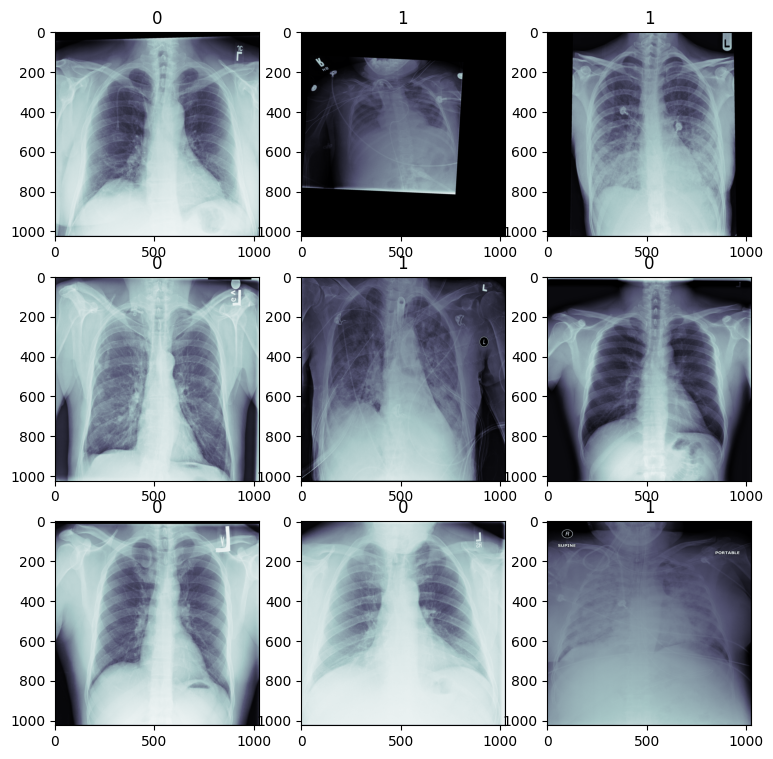

In [12]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(9):
  row, col = divmod(i, 3)
  dcm = pydicom.dcmread(image_list[i]).pixel_array
  label = target_list[i]

  axis[row, col].imshow(dcm, cmap='bone')
  axis[row, col].set_title(label)

In [13]:
ROOT_PATH

PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images')

In [15]:
print(len(os.listdir(ROOT_PATH)))
print(len(os.listdir(Path(root+'stage_2_test_images'))))

1000
100


In [ ]:
lentrain = 800

count = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
  dcm_path = ROOT_PATH/patient_id
  dcm_path = dcm_path.with_suffix('.dcm')

  if os.path.exists(dcm_path):
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255  # uint8 => 0 ~ 1 float32
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    label = labels.Target.iloc[c]

    train_or_val = 'train' if count < 800 else 'val'
    current_save_path = SAVE_PATH / train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)

    count += 1

In [17]:
print(root)
print(ROOT_PATH)

/content/drive/MyDrive/AI_application/pn_data_n1000/
/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images


In [19]:
print(len(os.listdir(root + "Processed/train/0")))
print(len(os.listdir(root + "Processed/train/1")))

print(len(os.listdir(root + "Processed/val/0")))
print(len(os.listdir(root + "Processed/val/1")))

527
273
142
58


In [18]:
mean = 0.39
std = 0.29

In [20]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomAffine(
        (-5, 5), (0, 0.05), (0.9, 1.1)),
    transforms.RandomResizedCrop(
        (224, 224), (0.8, 1)
    )
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [21]:
def load_file(path):
  return np.load(path).astype(np.float32)

train_dataset = datasets.DatasetFolder(
    root = os.path.join(SAVE_PATH, 'train'),
    loader = load_file,
    extensions = 'npy',
    transform = train_transform
)

val_dataset = datasets.DatasetFolder(
    root = os.path.join(SAVE_PATH, 'val'),
    loader = load_file,
    extensions = 'npy',
    transform = val_transform
)

In [24]:
from random import shuffle
batch_size = 64

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                          batch_size=batch_size,
                          shuffle=False)

In [25]:
weights = models.ResNet18_Weights.IMAGENET1K_V1
resnet18 = models.resnet18(weights=weights)
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
## model

weights = models.ResNet18_Weights.IMAGENET1K_V1
resnet18 = models.resnet18(weights=weights)

class PneumoniaModel(nn.Module):
  def __init__(self):
    super().__init__()

    weights = models.ResNet18_Weights.IMAGENET1K_V1
    self.resnet18 = models.resnet18(weights=weights)

    for param in self.resnet18.parameters():
      param.requires_grad = False

    self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.resnet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    self.feature_map = nn.Sequential(*list(self.resnet18.children())[:-2])

  def forward(self, data):
    pred = self.resnet18(data)

    return pred

In [29]:
resnet18 = PneumoniaModel().to(device)

In [30]:
lr = 1e-2
weight = 2

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
optimizer = optim.SGD(resnet18.parameters(), lr=lr, momentum=0.9)

In [ ]:
# PYTORCH_CUDA_ALLOC_CONF=expandable_segments
# torch.cuda.empty_cache()
# 반복 횟수

num_epochs = 10

# 평가 결과 기록
history = []
acc = 0.0
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0

    resnet18.train()
    print("training")
    for X, Y in tqdm(train_loader):

        data, target = X.to(device), Y.to(device) # X shape = torch.Size([64, 1, 224, 224]), target shape = torch.Size([64])
        output = resnet18(data)
        # output shape = torch.Size([64, 1])
        loss = criterion(output.squeeze(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.where(output.squeeze() < 0.0, 0, 1)
        train_loss += loss.item()
        train_acc += (predicted == target).float().mean().item()

    # scheduler.step()
    avg_loss = train_loss/len(train_loader)
    avg_acc = train_acc/len(train_loader)
    print(f"epoch = {epoch}, avg_train_loss = {avg_loss}, avg_train_acc = {avg_acc}")


    resnet18.eval()
    print("validating")
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for X_, Y_ in tqdm(val_loader):
            data_, target_ = X_.to(device), Y_.to(device)
            output_ = resnet18(data_)
            val_loss = criterion(output_.squeeze(), target_.float())
            predicted_ = torch.where(output_.squeeze() < 0.0, 0, 1)
            val_loss += val_loss.item()
            val_acc += (predicted_ == target_).float().mean().item()

    avg_loss_ = val_loss/len(val_loader)
    avg_acc_ = val_acc/len(val_loader)
    print(f"avg_val_loss = {avg_loss_}, avg_val_acc = {avg_acc_}")

    if acc < avg_acc_:
        acc = avg_acc_
        torch.save(resnet18.state_dict(), f"chest_x_epoch_{num_epochs}.pth") # model.load_state_dict(torch.load('chest_x.pth'))
        print("model saved!")

# Reinforcement Learning

In [133]:
!pip install keyboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.3 MB/s eta 0:00:00


In [134]:
import os
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import time
import keyboard

### Frozen Lake environment

In [127]:
## env import
env = gym.make("FrozenLake-v1",
               desc = None, map_name='4x4', is_slippery=False)

In [128]:
## env init
env.reset()

print('action =', env.action_space.n)
print('observation =', env.observation_space.n)
# display('transition prob = \n', env.unwrapped.P)
print('='*50)

## take action
state, reward, terminated, truncated, info = env.step(2)  # (1, 0.0, False, False, {'prob': 1.0})
print('state =', state)
print('reward =', reward)
print('terminated =', terminated)
print('truncated =', truncated)
print('info =', info)

print('='*50)
state, reward, terminated, truncated, info = env.step(1)
print('state =', state)
print('reward =', reward)
print('terminated =', terminated)
print('truncated =', truncated)
print('info =', info)

action = 4
observation = 16
state = 1
reward = 0.0
terminated = False
truncated = False
info = {'prob': 1.0}
state = 5
reward = 0.0
terminated = True
truncated = False
info = {'prob': 1.0}


## Frozen lake RL precess

In [129]:
##
env = gym.make('FrozenLake-v1', desc=None, map_name='4x4', is_slippery=False)

## init
obs, _ = env.reset()
print(f'initial state = {obs}')

##
print(f'action space = {env.action_space.n}')

## take action
action = env.action_space.sample()
print(f'action = {action}')
print('='*50)

## next state
state, reward, terminated, truncated, info = env.step(action)
print('next state =', state)
print('reward =', reward)
print('terminated =', terminated)
print('truncated =', truncated)
print('info =', info)

initial state = 0
action space = 4
action = 1
next state = 4
reward = 0.0
terminated = False
truncated = False
info = {'prob': 1.0}


## 확정적 환경 (Deterministic environment)

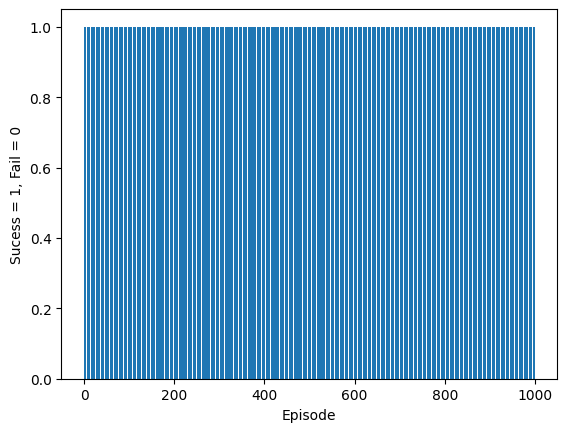

In [137]:
##
env = gym.make("FrozenLake-v1",
               desc=None,
               map_name='4x4',
               is_slippery=False)

s, _ = env.reset()

## deterministic policy
policy = {0:1, 1:2, 2:1, 3:0, 4:1, 6:1, 8:2, 9:1, 10:1, 13:2, 14:2}

scores = []
stochastic = False

for i in range(1000):
  terminated, truncated = False, False
  s, info = env.reset()
  score = 0

  while not terminated and not truncated:
    if stochastic:
      action = env.action_space.sample()
    else:
      action = policy[s]

    s_, reward, terminated, truncated, info = env.step(action)
    score += reward
    s = s_

  scores.append(score)

env.close()

plt.bar(np.arange(len(scores)), scores)
plt.xlabel('Episode')
plt.ylabel('Sucess = 1, Fail = 0')
plt.show()